In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from nsvd import NSVD

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

cuda


In [2]:
train = NSVD()
train_inputs = train.data.to(device)
train_targets = train.targets.to(device)

mean = train_inputs.mean()
std = train_inputs.std()
train_inputs = (train_inputs - mean) / std

batch_size = 36
train_input_batches = torch.split(train_inputs, batch_size)
train_target_batches = torch.split(train_targets, batch_size)
print(train_input_batches[0].shape)
print(train_target_batches[0].shape)

torch.Size([36, 3, 128, 128])
torch.Size([36, 2])


In [3]:
print(train_inputs.dtype, train_targets.dtype)

torch.float32 torch.float32


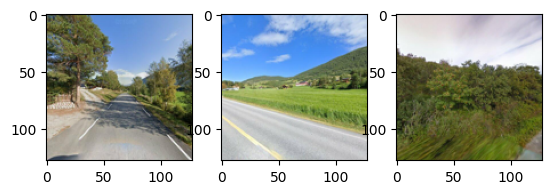

In [4]:
fig, axs = plt.subplots(1, 3)

for i, ax in enumerate(axs.ravel()):
  d = train_inputs[i] * std + mean
  ax.imshow(d.int().cpu().detach().numpy().transpose(1, 2, 0))

In [5]:
class ConvModule(nn.Module):
  def __init__(self, in_features, out_features) -> None:
    super(ConvModule, self).__init__()
    self.conv = nn.Conv2d(in_features, out_features, 5, padding=2)
    self.norm = nn.BatchNorm2d(out_features)

  def forward(self, x) -> torch.Tensor:
    x = self.norm(self.conv(x))
    return torch.relu(x)

class NSVDModel(nn.Module):
  def __init__(self) -> None:
    super(NSVDModel, self).__init__()
    self.pool = nn.MaxPool2d(2)
    self.conv1 = ConvModule(3, 64)
    self.conv2 = ConvModule(64, 128)
    self.conv3 = ConvModule(128, 256)
    self.conv4 = ConvModule(256, 256)
    #self.conv5 = ConvModule(256, 256)
    self.l1 = nn.Linear(256*8*8, 1024)
    self.l2 = nn.Linear(1024, 2)
    
  def forward(self, x):
    x = self.pool(self.conv1(x)) # 256 -> 128
    x = self.pool(self.conv2(x)) # 128 -> 64
    x = self.pool(self.conv3(x)) # 64 -> 32
    x = self.pool(self.conv4(x)) # 32 -> 16
    #x = self.pool(self.conv5(x)) # 16 -> 8
    x = x.reshape(-1, 256*8*8)
    x = torch.relu(self.l1(x))
    x = self.l2(x)
    return x


In [18]:
model = NSVDModel()
model.to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

epochs = 50
for epoch in range(epochs):
  epoch_loss = 0
  for batch in range(len(train_input_batches)):
    y = model(train_input_batches[batch])
    loss = loss_fn(y, train_target_batches[batch])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    epoch_loss += loss
  print("epoch: {}; loss: {}".format(epoch, epoch_loss/len(train_input_batches)))
  

epoch: 0; loss: 150.05104064941406
epoch: 1; loss: 23.267629623413086
epoch: 2; loss: 22.035524368286133
epoch: 3; loss: 21.107807159423828
epoch: 4; loss: 20.188312530517578
epoch: 5; loss: 19.248775482177734
epoch: 6; loss: 18.37632179260254
epoch: 7; loss: 17.541372299194336
epoch: 8; loss: 16.698251724243164
epoch: 9; loss: 15.8753023147583
epoch: 10; loss: 15.036561965942383
epoch: 11; loss: 14.157012939453125
epoch: 12; loss: 13.21516227722168
epoch: 13; loss: 12.136287689208984
epoch: 14; loss: 10.979694366455078
epoch: 15; loss: 9.736807823181152
epoch: 16; loss: 8.2841215133667
epoch: 17; loss: 6.977035999298096
epoch: 18; loss: 6.217178821563721
epoch: 19; loss: 6.882376670837402
epoch: 20; loss: 12.752946853637695
epoch: 21; loss: 9.956323623657227
epoch: 22; loss: 10.161090850830078
epoch: 23; loss: 9.192158699035645
epoch: 24; loss: 6.280506610870361
epoch: 25; loss: 6.870268821716309
epoch: 26; loss: 10.237579345703125
epoch: 27; loss: 14.619284629821777
epoch: 28; loss: 

In [62]:
torch.save(model, './data/model')

In [35]:
test_images = [{'file':'1TZm7ZnLMr', 'loc':[69.1326326,23.3151797]}]
test_im = np.random.choice(test_images, 1)[0]
test_im

{'file': '1TZm7ZnLMr', 'loc': [69.1326326, 23.3151797]}

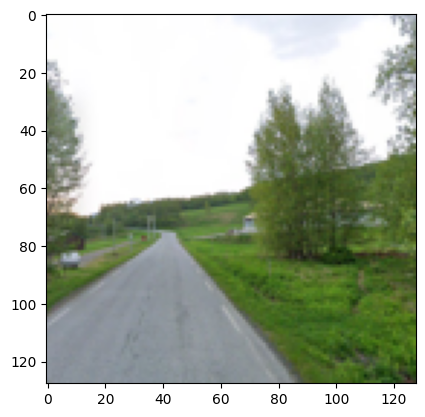

In [36]:
from PIL import Image

im = Image.open('./data/test_images/{}.png'.format(test_im['file'])).convert('RGB')
w, h = im.size
left = int((w - 512)/2)
top = int((h - 512)/2)
right = int((w + 512)/2)
bottom = int((h + 512)/2)

im = im.crop((left, top, right, bottom)).resize((128, 128))
im_data = torch.tensor(np.asarray(im).transpose(2, 0, 1))

plt.imshow(im_data.int().numpy().transpose(1, 2, 0))

In [37]:
im_data = im_data.to(device)
im_data = (im_data - mean) / std

y = model(im_data.unsqueeze(0)).flatten()
guessed_loc = (y[0].item(), y[1].item())
print(guessed_loc)

(67.03337097167969, 10.511999130249023)


In [38]:
import folium

real_loc = test_im['loc']

m = folium.Map((64.9701, 13.509217), zoom_start=4)
folium.CircleMarker(location=(real_loc[0], real_loc[1]), tooltip='real', radius=1, color='#0080bb', fill_color='#0080bb').add_to(m)
folium.CircleMarker(location=(guessed_loc[0], guessed_loc[1]), tooltip='guessed', radius=1, color='#d40834', fill_color='#d40834').add_to(m)
m
